# Applying what you've learned in the Watsonx.ai Boot Camp
The following notebook uses zero-shot text classification for financial services complaint classification.  However it was not written using the IBM GenAI Prompt Patterns functionality and would also benefit from using a more effective few-shot learning technique to improve model accuracy.

## To complete the Watsonx.ai Boot Camp
You will now apply the lessons you've learned to:
1. Refactor this notebook to use the IBM GenAI Python library's Prompt Patterns functionality.
2. Implement a better few-shot learning technique to improve model accuracy.
3. How much can you improve model performance?

## Your mission?  Do better than the person next to you
This notebook's accuracy is 72.51%.  Don't just do better than this notebook.  Which one of you can engineer the best prompt?

# Dataset
The Consumer Financial Protection Bureau (CFPB) is a federal U.S. agency that acts as a mediator when disputes arise between financial institutions and consumers. Via a web form, consumers can send the agency a narrative of their dispute. The goal is to automate complain classification to automate routing to the appropriate teams more efficiently.

The data file was downloaded directly from the CFPB website and included one year's worth of data (March 2020 to March 2021). Each webiste submission was tagged with one of five financial classes:

- credit cards
- credit reporting
- debt collection
- mortgages and loans (includes car loans, payday loans, student loans, etc.)
- retail banking (includes checking/savings accounts, as well as money transfers, Venmo, etc.)

After data cleaning, the dataset consisted of around 162,400 consumer submissions containing narratives. The dataset is imbalanced with 56% in the credit reporting class with the remainder roughly equally distributed (between 8% and 14%) among the remaining classes.

**Note:** This dataset was selected based on prior work on this dataset here: https://github.com/halpert3/complaint-content-classification-nlp

# Table of Contents

* [Step 1. Initialize system](#fm_initialize)
* [Step 2. Select the Model and Set Parameters](#fm_params)
* [Step 3. Prepare the Input Data](#fm_input)
* [Step 4. Run the Model Iterating over a Sample of the Dataset](#fm_iterate)
* [Step 5. Merge and Examine the Output Data](#fm_merge_examine)
* [Step 6. Analyze the Results](#fm_analyze)
* [Step 7. Submit Your Notebook for Review](#fm_submit_notebook)

<a id="fm_initialize"></a>
# Step 1. Initialize System

### 1.1 Import libraries
Import libraries and configure the system
We import the required libraries and IBM Generative AI modules.

In [2]:
import csv
from dotenv import load_dotenv
import pandas as pd
import json
import matplotlib.pyplot as plt
import os
import plotly.graph_objects as go
import plotly.express as px
from genai.services import ServiceInterface
from genai.model import Credentials, Model
from genai.schemas import GenerateParams, ModelType

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

### 1.2 Import config file

To support greater flexibility and configuration, this notebook uses a *config.json* file containing these options:
- `input_file_path`: The file path for the input data file for analysis in a CSV format.
- `output_file_path`: The file path for storing the classification data output.
- `input_value`: The header name of the input sentences from the input data CSV file.
- `original_category`: The header name of the original category from the input data CSV file.
- `classifications`: An array containing all categories.
- `misclassified_file_path`: The file path for storing the misclassified data.
- `output_file_header`: An array of headers to specify the output file column order.
- `sample_size`: The percentage of the input file to be sampled for processing.
- `params`: These additional parameters specify the model behavior.
	- `decoding_method`: This specifies the strategy for selecting tokens during the generation of the output text. This parameter can take on values of "greedy" or "sample", with "sample" as the default value if not specified.
	- `max_new_tokens`: The maximum number of new tokens to be generated. This parameter ranges from 1 to 1024, with a default value 20.
	- `min_new_tokens`: If stop sequences are given, they are ignored until the minimum tokens are generated. The parameter defaults to 0.
	- `random_seed`: Random number generator seed to use in sampling mode for experimental repeatability. The *random_seed* Must be greater than or equal to one.
	- `stop_sequences`: Stop sequences are one or more strings that will cause the text generation to stop when they are produced in the output.
	- `temperature`: The *temperature* modifies the next-token probabilities when running in sampling mode.
	- `top_k`: The number of highest probability vocabulary tokens to retain for top-k-filtering.
	- `top_p`: This parameter is similar to top_k, except the candidates to generate the next token are the most likely tokens with probabilities that sum to at least top_p. 

There are additional parameters available for further customization, documented at [IBM Watson AI API Reference](https://workbench.res.ibm.com/docs/api-reference#generate).

In [3]:
with open('config.json', 'r') as f:
    json_data = json.load(f)
    params = GenerateParams(**json_data['params'])

temp_path = json_data['temp_path']
input_file_path_temp = os.path.join(temp_path,"inputTemp.csv")
output_file_path_temp = os.path.join(temp_path,"outputTemp.csv")
os.makedirs(temp_path, exist_ok=True)

output_path = json_data['output_path']
output_file_path = os.path.join(output_path,json_data['output_file'])
os.makedirs(output_path, exist_ok=True)


<a id="fm_params"></a>
# Step 2. Select the Model and Set Parameters
In this step we select a model and set the parameters specific to the model to control the behavior.

In the default example, the only parameter passed tothe models is decoding_method="greedy". When the *decoding_method* is set to "greedy", all generated text is included, so no additional parameters are needed.

You could explore using decoding_method="sample" and then set several additional parameters to control text generation. The *temperature* parameter adjusts the randomness of the model's output: setting it to 0.7 gives some randomness, but ensures the model isn't too random. The *min_new_tokens* and *max_new_tokens* parameters control the minimum and maximum number of new tokens the model can generate. The *top_k* and *top_p* parameters control how the model selects tokens from the predicted tokens, and are typically set to 50 and 1, respectively. With those settings, the model will choose the 50 most probable tokens and will not randomly select tokens.

In [4]:
# Ensure you copied the .env file that you created earlier into the same directory as this notebook
load_dotenv()
api_key = os.getenv("GENAI_KEY", None)
api_endpoint = os.getenv("GENAI_API", None)
if api_key is None or api_endpoint is None:
    print("Ensure you copied the .env file that you created earlier into the same directory as this notebook")
else:
    creds = Credentials(api_key=api_key, api_endpoint=api_endpoint)

creds = Credentials(api_key=api_key, api_endpoint=api_endpoint)
FLAN = Model(ModelType.FLAN_UL2, params=params, credentials=creds)

NameError: name 'api_url' is not defined

<a id="fm_input"></a>
# Step 3. Prepare the Input Data

## 3.1 Load configuration
Read input and specify indices are first column

In [158]:
input_file_path=json_data['input_file_path']
input_response = pd.read_csv(input_file_path, index_col=0)
input_response.head(5)

,narrative
classification,
credit_card,purchase order day shipping amount receive pro...
credit_card,forwarded message date tue subject please inve...
retail_banking,forwarded message cc sent friday pdt subject f...
credit_reporting,payment history missing credit report speciali...
credit_reporting,payment history missing credit report made mis...


## 3.2 Provide instructions to the model
Careful design of your instructions may seem easy to ignore but is a crucial step of Prompt Engineering.  As a test, try setting these instructions to an empty string "" to see how well the prompt performs without it

In [159]:
# Provide instructions to set context for the model
instructions = "Classify this financial text into one of these categories: "
instructions += ', '.join(json_data["classifications"]) + "\n\n"

## 3.3 Review example prompt
We assemble one example of the prompt that will be passed to the LLM, consisting of the classification request combined with the text to be analyzed.

In [160]:
def generate_prompt(input_value):
    return instructions + input_value

in_val=json_data["input_value"]
org_cat=json_data["original_category"]
with open(input_file_path, "r") as input_file:
    reader = csv.DictReader(input_file)
    for i, row in enumerate(reader):
        if i == 0:
            input_value = row[in_val]
            original_category = row[org_cat]
            example_prompt = generate_prompt(input_value)
            print(example_prompt)

Classify this financial text into one of these categories: credit_card, retail_banking, credit_reporting, mortgages_and_loans, debt_collection

purchase order day shipping amount receive product week sent followup email exact verbiage paid two day shipping received order company responded im sorry inform due unusually high order volume order shipped several week stock since early due high demand although continuing take order guaranteeing receive order place due time mask order exact shipping date right however guarantee ship soon soon delivers product u getting small shipment shipping first come first served basis appreciate patience fulfill order quickly recommend keeping order lose place line cancel distributor stock moment prefer cancel please note ask via email cancel accordance cancellation policy agreed checkout electronic inventory online requested order canceled refund issued canceled order sent verification order canceled refunded item particulate respirator refunded subtotal

<a id="fm_example_output"></a>
## 3.4 Review model response for prompt
We assemble one example of the prompt that will be passed to the LLM, consisting of the classification request combined with the text to be analyzed.

In [161]:
responses = FLAN.generate_async([example_prompt])
response = list(responses)[0]
classification = response.generated_text
input_text = response.input_text
input_text = input_text[len(instructions):len(input_text)]

print(f"The model classified the text as '{classification}'")

Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48 inputs/s]

The model classified the text as 'credit_card'


<a id="fm_iterate"></a>
# Step 4. Run the Model Iterating over a Sample of the Dataset
We now iterate through the entire dataset, constructing prompts for each input text entry  and submitting them to the LLM. The sample_percent parameter specifies the percentage of the input text entries that will be submitted to the LLM

In [163]:
reader = csv.reader(open(json_data['input_file_path']))
original_dataset_size = len(list(reader))
sample_percent = json_data["sample_percent"]
sample_size = int(( sample_percent / 100) * original_dataset_size)
print(f"{sample_percent}% or {sample_size} of {original_dataset_size} samples will be evaluated")

# Open the input and output CSV files
with open(json_data['input_file_path'], "r") as inf, open(input_file_path_temp, "w", newline="") as infT, open(output_file_path_temp, "w", newline="") as ouf:

    # Create CSV reader and writer objects
    reader = csv.DictReader(inf)
    writer = csv.DictWriter(ouf, fieldnames=json_data["output_file_header"])
    writer1 = csv.DictWriter(infT, fieldnames=["original_category", "narrative"])

    # Write the header row to the output CSV file
    writer.writeheader()
    writer1.writeheader()
     # Loop through each row in the input CSV file
    i=0
    prompts_to_complete = []
    completed_prompts = []
    print("creating prompts...")
    for row in reader:
        if i<sample_size:
            input_value = row[in_val]
            original_category = row[org_cat]
            writer1.writerow({"original_category": original_category, "narrative": input_value})
            i=i+1
            prompt = generate_prompt(input_value)
            prompts_to_complete.append(prompt)
            
    num_of_prompts = len(prompts_to_complete)
    print(f"{num_of_prompts} prompts created")

    # generate async on all prompts
    responses = FLAN.generate_async(prompts_to_complete)
    count = 0
    for response in responses:
        classification = response.generated_text
        input_text = response.input_text
        input_text = input_text[len(instructions):len(input_text)]
        count += 1
        writer.writerow({"index": count, "predicted_category": classification, "narrative": input_text})


0.5% of samples to be evaluated
creating prompts...
622 prompts created


Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:57<00:00, 10.85 inputs/s]


<a id="fm_merge_examine"></a>
# Step 5. Merge and Examine the Output Data

<a id="fm_merge_output"></a>
## 5.1 Merge output data
We next merge the input data with the processed output to create a single output file for analysis.

In [164]:
# Read the first CSV file with original category and narrative columns
df_input_temp = pd.read_csv(input_file_path_temp)

# Read the second CSV file with predicted category and narrative columns
df_output_temp = pd.read_csv(output_file_path_temp)

# Merge the two dataframes based on the narrative column
merged_df = pd.merge(df_input_temp, df_output_temp, on='narrative')
merged_df = merged_df.drop_duplicates(subset='narrative')

# Save the merged dataframe to a new CSV file
merged_df.to_csv(output_file_path, index=False)

<a id="fm_examine_output"></a>
## 5.2 Examine the model predictions
We can examine a small set of the combined data to compare the quality of the results. The data presented below shows the original_category (original sentiment) and the category predicted by the model (predicted sentiment). As can be seen, a majority of the categories in the small sample are predicted correctly and match. The combination of of the input and output data will allow us perform other analysis of the classification results. This is kept in memory as the *output_response* array for later access.

In [177]:
output_response = pd.read_csv(output_file_path, index_col=None)
output_response.head(5)

,original_category,narrative,index,predicted_category
0,credit_card,purchase order day shipping amount receive pro...,3,credit_card
1,credit_card,forwarded message date tue subject please inve...,1,credit_card
2,retail_banking,forwarded message cc sent friday pdt subject f...,4,credit_card
3,credit_reporting,payment history missing credit report speciali...,2,credit_reporting
4,credit_reporting,payment history missing credit report made mis...,5,credit_reporting


<a id="fm_analyze"></a>
# Step 6. Analyze the Results

<a id="fm_compare"></a>
## 6.1 Comparison
Compare the predicted and original categories to find the percentage that exactly match. A percentage of 100% indicates all predictions match the original classifications.

In [191]:
reader = csv.reader(open(output_file_path))
test_dataset_size = len(list(reader))
# Skip the header
test_dataset_size = test_dataset_size - 1

matched_rows = 0
with open(output_file_path, 'r') as csvfile:
    datareader = csv.reader(csvfile)
    for row in datareader:

        # get the values of the two columns to compare
        column1 = row[0]
        column2 = row[3]
        if column1 == column2:
            matched_rows+=1
match_percent = (matched_rows / test_dataset_size) * 100
print(f"{match_percent:.2f}% rows matched")
print(f"{matched_rows} of {test_dataset_size} rows matched")

72.51% rows matched
451 of 622 rows matched


<a id="fm_post_processing"></a>
## 6.2 Post-process the dataset in preparation for performance analysis

Here, we post-process the dataset and generate sets of the original and predicted categories. We then create a file of the misclassified data that will be used in later analysis.

In [181]:
print(pd.unique(output_response['original_category']))
print(pd.unique(output_response['predicted_category']))

['credit_card' 'retail_banking' 'credit_reporting' 'mortgages_and_loans'
 'debt_collection']
['credit_card' 'credit_reporting' 'mortgages_and_loans' 'debt_collection'
 'retail_banking']


In [182]:
attribute_list=list(pd.unique(output_response['original_category']))
attribute_list

['credit_card',
 'retail_banking',
 'credit_reporting',
 'mortgages_and_loans',
 'debt_collection']

In [183]:
original_valu_counts={}
predicted_valu_counts={}
for i in attribute_list:
    original_valu_counts['original_'+i]=output_response['original_category'].value_counts()[i]
    predicted_valu_counts['predicted_'+i]=output_response['predicted_category'].value_counts()[i]
print('original_valu_counts=',original_valu_counts)

print('\npredicted_valu_counts=',predicted_valu_counts)


original_valu_counts= {'original_credit_card': 68, 'original_retail_banking': 70, 'original_credit_reporting': 288, 'original_mortgages_and_loans': 97, 'original_debt_collection': 99}

predicted_valu_counts= {'predicted_credit_card': 181, 'predicted_retail_banking': 33, 'predicted_credit_reporting': 272, 'predicted_mortgages_and_loans': 80, 'predicted_debt_collection': 56}


In [192]:
misclassified_file_path = os.path.join(output_path,json_data['misclassified_file_path'])

misclassified_rows = 0
with open(output_file_path, 'r') as input_file, open(misclassified_file_path, 'w', newline='') as output_file:

    # create the CSV reader and writer objects
    csv_reader = csv.reader(input_file)
    csv_writer = csv.writer(output_file)

    # loop through each row in the input file
    for row in csv_reader:

        # get the values of the two columns to compare
        column1 = row[0]
        column2 = row[3]

        # compare the two columns
        if column1 != column2:
            # write the row to the output file
            csv_writer.writerow(row)
            misclassified_rows+=1

misclassified_percent = (misclassified_rows / test_dataset_size) * 100
print(f"{misclassified_percent:.2f}% rows were misclassified")
print(f"{misclassified_rows} of {test_dataset_size} rows were misclassified")

27.65% rows were misclassified
172 of 622 rows were misclassified


<a id="fm_accuracy_data"></a>
## 6.3 Prepare to compute model accuracy
We create a copy of the *output_response* array named *dff* and then create separate vectors of the original (*y_test*) and predicted (*y_pred*) categories for analysis.

In [199]:
dff= output_response.copy()
y_test=dff['original_category']
y_pred=dff['predicted_category']

<a id="fm_accuracy"></a>
## 6.4 Compute model accuracy

Comparing the original and predicted categories and displaying the accuracy score as computed by scikit-learn should give an accuracy value that matches what was computed in section 6.1.

In [200]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
print('Accuracy of model ',accuracy_score(y_test,y_pred)*100,'%')
#this value should match with Match percentage estimated in comparison cell above

Accuracy of model  72.508038585209 %


<a id="fm_confusion"></a>
## 6.5 Generate a confusion matrix
Next we compute and display the confusion matrix that characterizes the correct and incorrect categorizations and displays them graphically. Correct matches appear along a top-left to bottom-right diagonal. Cells with higher numbers of entries are shown in yellow ranging across the spectrum to lower numbers of entries shown in purple.

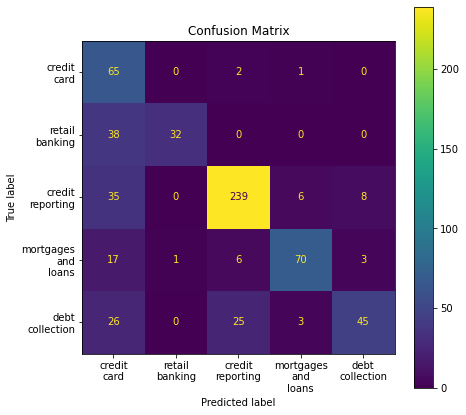

In [201]:
from sklearn.metrics import ConfusionMatrixDisplay
from textwrap import wrap
xy_label=['\n'.join(attribute.split('_')) for attribute in  attribute_list]
cm = confusion_matrix(y_test, y_pred,labels=attribute_list)
# print('Confusion Matrix \n',cm)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=xy_label)
fig, ax = plt.subplots(figsize=(7,7))
plt.title('Confusion Matrix')
cm_display.plot(ax=ax)
# plt.setp(ax.get_xticklabels(), rotation=20)
plt.show()

<a id="fm_submit_notebook"></a>
##  Finished?
Submit your completed notebook to Anthony Stevens at apsteven@us.ibm.com.  

**NOTE:** Thanks to Mishal Dholakia as this notebook is based off his earlier work on a [Watsonx.ai classification notebook](https://github.ibm.com/Research-Notebooks/foundation-model/blob/main/01_Zero_shot_classification.ipynb).  You can also contact that by email at IBM.Research.JupyterLab@ibm.com.